In [1]:
# Model training of text classiffiers using logreg, svm, mlp 
# Violeta Berdejo-Espinola, Akos Hajas, Nan Ye
# November 2024

In [2]:
%pip install mpu scikit-learn imblearn embetter sentence_transformers matplotlib ipywidgets

  Using cached mpu-0.23.1-py3-none-any.whl (69 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 8.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 13.3 MB/s eta 0:00:0000:0100:01
  Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 16.9 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 10.8 MB/s eta 0:00:0000:010:01
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached torch-2.5.1-cp311-none-maco

# read data

In [3]:
import mpu

# raw corpus

corpus_raw = mpu.io.read('../data/corpus_raw.pickle')
corpus_raw_long = mpu.io.read('../data/corpus_raw_long.pickle')

x_raw = corpus_raw
x_raw_long = corpus_raw_long

# clean corpus

corpus = mpu.io.read('../data/corpus_clean.pickle')
corpus_long = mpu.io.read('../data/corpus_clean_long.pickle')

x = corpus
x_long = corpus_long

# pos, negs

pos = mpu.io.read('../data/pos.pickle')
neg = mpu.io.read('../data/neg.pickle')
y = [1] * len(pos) + [0] * len(neg)

In [4]:
weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 

# split data

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train_long, x_test_long, y_train_long, y_test_long = train_test_split(x_long, y, test_size=0.20, random_state=42)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_raw, y, test_size=0.20, random_state=42)
x_train_r_long, x_test_r_long, y_train_r_long, y_test_r_long = train_test_split(x_raw_long, y, test_size=0.20, random_state=42)

In [6]:
from collections import Counter

counter = Counter()

for i in y_test:
    counter[i] +=1
    
print(counter)

Counter({0: 991, 1: 13})


# instantiate feature extractors, embedding models, resamplers, models 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer # uses one-dim array of strings ~ shape (n,)
from sklearn.feature_extraction.text import CountVectorizer # returns arrays

vect_cv = CountVectorizer()
vect_tfidf = TfidfVectorizer()

model_mpnet = 'paraphrase-multilingual-mpnet-base-v2'
model_distill = 'distiluse-base-multilingual-cased-v1'

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN 

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')
ada = ADASYN(random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42)
svm = SVC(kernel='linear')
svm_weight = SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True)
mlp = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',learning_rate_init=0.001, solver='adam', random_state=42)
mlp_t = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(5,), learning_rate='invscaling',learning_rate_init=1, solver='sgd', random_state=42, max_iter=400)

# function to train eval models

In [8]:
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, precision_score, recall_score

import pandas as pd

In [9]:
# TF TFIDF baseline and weighted

def train_eval_tf_tfidf(x_train, y_train, x_test, y_test, text_length, kfold):
    
    def run_estimator(estimator, feature_extractor, balanced):
        
        pipeline = Pipeline([("vectorizer", feature_extractor),
                             ("estimator", estimator)
                            ])
    
        y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') # cross val splits the data and then applies the pipeline steps

        pipeline.fit(x_train, y_train)
        
        y_train_pred = pipeline.predict(x_train)

        y_test_pred = pipeline.predict(x_test)

        return {
            'Classifier': pipeline['estimator'],
            'Feature_extraction': pipeline['vectorizer'],
            'Weighting': 'Weighted' if balanced else 'None',
            'CV': kfold,
            'Text_length': text_length,
            'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
            'F1_tr': round(f1_score(y_train, y_train_pred), 3),
            'F1_ts': round(f1_score(y_test, y_test_pred), 3),
            'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
            'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
            'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
            'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
            'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
            'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }


    all_scores = []
    
    for feature_extractor in [vect_cv, vect_tfidf]:
        
        for estimator in [logreg, svm]:
            all_scores.append(run_estimator(estimator, feature_extractor, False))
            
        for estimator in [logreg_weight, svm_weight]: 
            all_scores.append(run_estimator(estimator, feature_extractor, True))

    return all_scores

In [10]:
# embeddings baseline and weighted

def train_eval_embeddings(x_train, y_train, x_test, y_test, text_length, kfold):
    
    def run_estimator(estimator, balanced):
        
        pipeline = make_pipeline(
            SentenceEncoder(embedding_model),
            estimator
        )
    
        y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

        pipeline.fit(x_train, y_train)
        
        y_train_pred = pipeline.predict(x_train)

        y_test_pred = pipeline.predict(x_test)

        return {
            'Classifier': estimator,
            'Feature_extraction': embedding_model,
            'Weighting': 'Weighted' if balanced else None,
            'CV': kfold,
            'Text_length': text_length,
            'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
            'F1_tr': round(f1_score(y_train, y_train_pred), 3),
            'F1_ts': round(f1_score(y_test, y_test_pred), 3),
            'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
            'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
            'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
            'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
            'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
            'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }


    all_scores = []
    
    for embedding_model in [model_mpnet, model_distill]:
        
            for estimator in [logreg, svm, mlp, mlp_t]:
                all_scores.append(run_estimator(estimator, False))
                
            for estimator in [logreg_weight, svm_weight]: 
                all_scores.append(run_estimator(estimator, True))

    return all_scores

In [11]:
# TF TFIDF resampled

def train_eval_tf_tfidf_resampled(x_train, y_train, x_test, y_test, text_length, kfold):
    
    all_scores = []
    
    for feature_extractor in [vect_cv, vect_tfidf]:
        
        for resampler in [rus, ros, ada]:
        
            for estimator in [logreg, svm, mlp]:
        
                pipeline = Pipeline([("vectorizer", feature_extractor),
                                    ("resampler", resampler),
                                    ("estimator", estimator)
                                    ])
        
                y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

                pipeline.fit(x_train, y_train)
                
                y_train_pred = pipeline.predict(x_train)

                y_test_pred = pipeline.predict(x_test)

                scores = {
                    'Classifier': pipeline['estimator'],
                    'Feature_extraction': pipeline['vectorizer'],
                    'Weighting': pipeline['resampler'],
                    'CV': kfold,
                    'Text_length': text_length,
                    'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
                    'F1_tr': round(f1_score(y_train, y_train_pred), 3),
                    'F1_ts': round(f1_score(y_test, y_test_pred), 3),
                    'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
                    'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
                    'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
                    'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
                    'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
                    'Recall_ts': round(recall_score(y_test, y_test_pred), 3)    
                }
    
                all_scores.append(scores)

    return all_scores

In [12]:
# embeddings resampled

def train_eval_embedding_resampled(x_train, y_train, x_test, y_test, text_length, kfold, embed_model):
    
    all_scores = []
    
    pipeline = make_pipeline(
        SentenceEncoder(embed_model),
        RandomOverSampler(random_state=42, sampling_strategy='not majority'),
        MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',learning_rate_init=0.001, solver='adam', random_state=42)
    )
                                
    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': mlp,
        'Feature_extraction': embed_model,
        'Weighting': ros,
        'CV': kfold,
        'Text_length': text_length,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)    
    }

    all_scores.append(scores)

    return all_scores

# train eval models

In [13]:
# TF TFIDF baseline and weighted

df1 = pd.DataFrame(train_eval_tf_tfidf(x_train, y_train, x_test, y_test,'Title_Abstract',2))
df2 = pd.DataFrame(train_eval_tf_tfidf(x_train_long, y_train_long, x_test_long, y_test_long,'Title_Abstract_Main',2))

/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [14]:
# embeddings baseline and weighted

df3 = pd.DataFrame(train_eval_embeddings(x_train_r, y_train_r, x_test_r, y_test_r,'Title_Abstract',2))
df4 = pd.DataFrame(train_eval_embeddings(x_train_r_long, y_train_r_long, x_test_r_long, y_test_r_long,'Title_Abstract_Main',2))

/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [15]:
# TF TFIDF resampled

df5 = pd.DataFrame(train_eval_tf_tfidf_resampled(x_train, y_train, x_test, y_test,'Title_Abstract',2))
df6 = pd.DataFrame(train_eval_tf_tfidf_resampled(x_train_long, y_train_long, x_test_long, y_test_long,'Title_Abstract_Main',2))

/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

In [16]:
# embeddings resampled

df7 = pd.DataFrame(train_eval_embedding_resampled(x_train_r, y_train_r, x_test_r, y_test_r,'Title_Abstract',2, model_mpnet))
df8 = pd.DataFrame(train_eval_embedding_resampled(x_train_r_long, y_train_r_long, x_test_r_long, y_test_r_long,'Title_Abstract_Main',2, model_mpnet))

df9 = pd.DataFrame(train_eval_embedding_resampled(x_train_r, y_train_r, x_test_r, y_test_r,'Title_Abstract',2, model_distill))
df10 = pd.DataFrame(train_eval_embedding_resampled(x_train_r_long, y_train_r_long, x_test_r_long, y_test_r_long,'Title_Abstract_Main',2, model_distill))

/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/uqvberde/Dropbox/translate/1.synthesis/scripts/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

# cocatenate model results

In [17]:
res = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10])
res = res.sort_values(by='Recall_tr_cv', ascending=False).reset_index(drop=True)
res 

,Classifier,Feature_extraction,Weighting,CV,Text_length,F1_tr_cv,F1_tr,F1_ts,Precision_tr_cv,Precision_tr,Precision_ts,Recall_tr_cv,Recall_tr,Recall_ts
0,"MLPClassifier(activation='logistic', batch_siz...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,Title_Abstract,0.056,0.075,0.059,0.029,0.039,0.031,0.918,1.00,0.769
1,"MLPClassifier(activation='logistic', batch_siz...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,Title_Abstract_Main,0.055,0.072,0.065,0.028,0.038,0.033,0.898,1.00,0.923
2,"MLPClassifier(activation='logistic', batch_siz...",CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,Title_Abstract,0.065,0.091,0.072,0.034,0.048,0.038,0.878,1.00,0.769
3,SVC(kernel='linear'),TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,Title_Abstract,0.076,0.118,0.079,0.040,0.062,0.042,0.857,1.00,0.692
4,"LogisticRegression(random_state=42, solver='li...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,Title_Abstract,0.075,0.112,0.076,0.039,0.059,0.040,0.857,1.00,0.692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,"LogisticRegression(random_state=42, solver='li...",paraphrase-multilingual-mpnet-base-v2,None,2,Title_Abstract_Main,0.000,0.040,0.143,0.000,1.000,1.000,0.000,0.02,0.077
76,"MLPClassifier(activation='logistic', batch_siz...",paraphrase-multilingual-mpnet-base-v2,None,2,Title_Abstract,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
77,"MLPClassifier(activation='logistic', batch_siz...",distiluse-base-multilingual-cased-v1,None,2,Title_Abstract,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
78,SVC(kernel='linear'),distiluse-base-multilingual-cased-v1,None,2,Title_Abstract,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000


In [18]:
res.to_csv('../results/preliminary/model_results_dec2024_embedd.csv')

# best performing model

In [19]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

# predict probabilities and calculate model loss
# log_likelihood = y_test*np.log(y_pred) + (1-y_test)*np.log(1-y_pred)

In [20]:
def train_eval_best_model(x_train, y_train, x_test, y_test, text_length, kfold, embedding_model, random_state):
    
    pipeline = make_pipeline(
        SentenceEncoder(embedding_model),
        LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=random_state)
    )

    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': 'Log_reg',
        'Feature_extraction': embedding_model,
        'Weighting': 'Weighted',
        'CV': kfold,
        'Text_length': text_length,
        'Solver': 'Liblinear',
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    # train set
    y_pred_tr = pipeline.predict_proba(x_train) # predict_proba returns probabilities of a classification label
    logloss_tr = log_loss(y_train, y_pred_tr) 

    # test set
    y_pred_ts = pipeline.predict_proba(x_test)  
    logloss_ts = log_loss(y_test, y_pred_ts)
    
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
 
    return scores, y_pred_ts, logloss_tr, logloss_ts

In [21]:
# best model 

best_model = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 'Title_Abstract', 2, model_distill, 42)
best_model

loss training set: 0.1897658682525481, 
loss test set 0.20294582318626886
confusion matrix train set:
[[3705  261]
 [   0   49]]
confusion matrix test set:
[[916  75]
 [  1  12]]


({'Classifier': 'Log_reg',
  'Feature_extraction': 'distiluse-base-multilingual-cased-v1',
  'Weighting': 'Weighted',
  'CV': 2,
  'Text_length': 'Title_Abstract',
  'Solver': 'Liblinear',
  'F1_tr_cv': 0.167,
  'F1_tr': 0.273,
  'F1_ts': 0.24,
  'Precision_tr_cv': 0.1,
  'Precision_tr': 0.158,
  'Precision_ts': 0.138,
  'Recall_tr_cv': 0.51,
  'Recall_tr': 1.0,
  'Recall_ts': 0.923},
 array([[0.42389789, 0.57610211],
        [0.92312641, 0.07687359],
        [0.85360323, 0.14639677],
        ...,
        [0.99124582, 0.00875418],
        [0.93991575, 0.06008425],
        [0.23088369, 0.76911631]], shape=(1004, 2)),
 0.1897658682525481,
 0.20294582318626886)

# investigating performance on different train-test partitions

In [22]:
# run on a few different train-test partitions, then report the average with the standard error.
# I should see greater performance with more data, but also lower variance across the different random samples

In [23]:
m_seeds = [train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 'Title_Abstract', 2, model_distill, seed) for seed in [24, 36, 64, 128]]

m_seeds = [m_seeds[0][2], m_seeds[1][2], m_seeds[2][2], m_seeds[3][2], best_model[2]]

from statistics import stdev

std_dev = stdev(m_seeds)
std_dev # logloss


loss training set: 0.1897658682525481, 
loss test set 0.20294582318626886
confusion matrix train set:
[[3705  261]
 [   0   49]]
confusion matrix test set:
[[916  75]
 [  1  12]]
loss training set: 0.1897658682525481, 
loss test set 0.20294582318626886
confusion matrix train set:
[[3705  261]
 [   0   49]]
confusion matrix test set:
[[916  75]
 [  1  12]]
loss training set: 0.1897658682525481, 
loss test set 0.20294582318626886
confusion matrix train set:
[[3705  261]
 [   0   49]]
confusion matrix test set:
[[916  75]
 [  1  12]]
loss training set: 0.1897658682525481, 
loss test set 0.20294582318626886
confusion matrix train set:
[[3705  261]
 [   0   49]]
confusion matrix test set:
[[916  75]
 [  1  12]]


0.0

# plot predicted probabilities


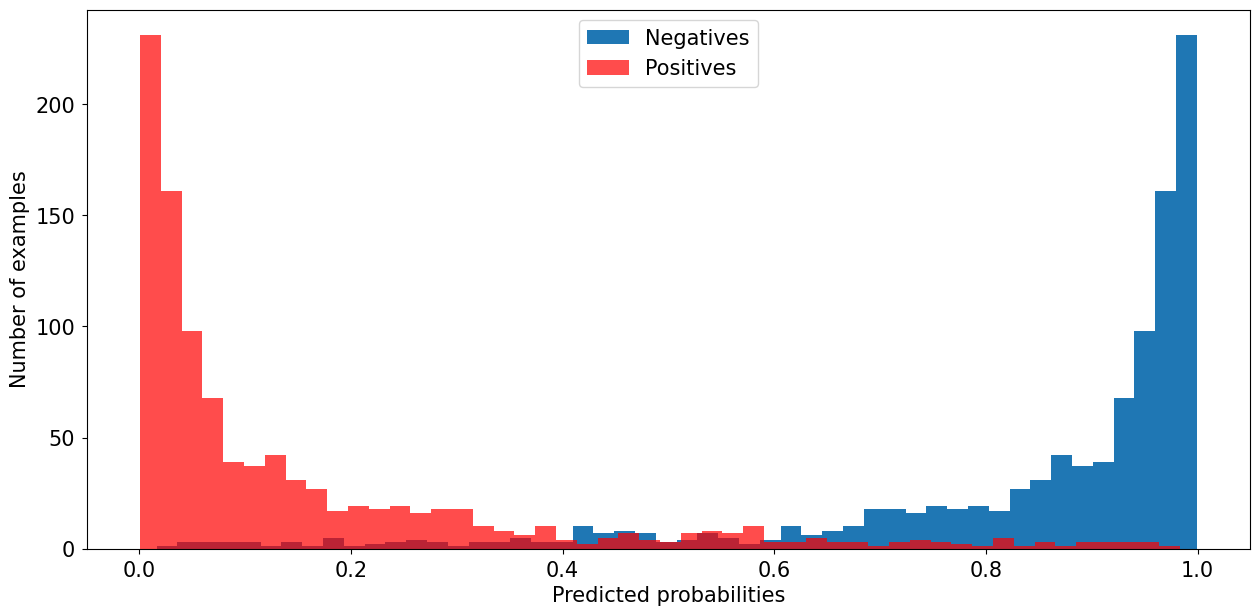

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

y_pred_ts_p = best_model[1][:,1] # subset class of interest --> 1d array
y_pred_ts_n = best_model[1][:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=50, label='Negatives')
plt.hist(y_pred_ts_p, bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.show() 
plt.savefig('../results/preliminary/predicted_proba_logreg_ts.png', dpi=800)

# roc


In [26]:
# function to predict probabilities, compute auc score and roc curve 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_auc_roc(estimator, embedding_model, x_train, y_train, x_test, y_test, random_state):
    
    pipeline = make_pipeline(
        SentenceEncoder(embedding_model),
        LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=random_state)
    )
    
    # y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    pred_prob = pipeline.predict_proba(x_test)
    y_pred = pipeline.predict(x_test)

    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    
    return auc_score, fpr, tpr, pred_prob, y_pred

# roc curve for tpr = fpr 

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_lr_weight_distill, fpr_lr_weight_distill, tpr_lr_weight_distill, y_pred_proba_lr_weight_distill, y_pred_lr_weight__distill= get_auc_roc(logreg_weight, model_distill, x_train_r, y_train_r, x_test_r, y_test_r, 42)
auc_lr_weight_mpnet, fpr_lr_weight_mpnet, tpr_lr_weight_mpnet, y_pred_proba_lr_weight_mpnet, y_pred_lr_weight_mpnet= get_auc_roc(logreg_weight, model_mpnet, x_train_r, y_train_r, x_test_r, y_test_r, 42)
auc_svm_weight_distill, fpr_svm_weight_distill, tpr_svm_weight_distill, y_pred_proba_svm_weight_distill, y_pred_svm_weight_distill= get_auc_roc(svm_weight, model_distill, x_train_r, y_train_r, x_test_r, y_test_r, 42)
auc_svm_weight_mpnet, fpr_svm_weight_mpnet, tpr_svm_weight_mpnet, y_pred_proba_svm_weight_mpnet, y_pred_svm_weight_mpnet= get_auc_roc(svm_weight, model_mpnet, x_train_r, y_train_r, x_test_r, y_test_r, 42)


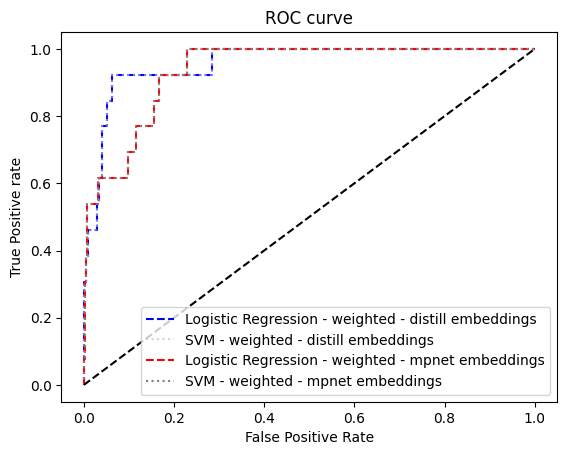

In [38]:
import matplotlib.pyplot as plt
# plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_lr_weight_distill, tpr_lr_weight_distill, linestyle='--',color='blue', label='Logistic Regression - weighted - distill embeddings')
plt.plot(fpr_svm_weight_distill, tpr_svm_weight_distill, linestyle='dotted',color='#bbca', label='SVM - weighted - distill embeddings')
plt.plot(fpr_lr_weight_mpnet, tpr_lr_weight_mpnet, linestyle='--',color='red', label='Logistic Regression - weighted - mpnet embeddings')
plt.plot(fpr_svm_weight_mpnet, tpr_svm_weight_mpnet, linestyle='dotted',color='gray', label='SVM - weighted - mpnet embeddings')

plt.plot(p_fpr, p_tpr, linestyle='--', color='black')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('../results/ROC.png',dpi=800)
plt.show();

#

# error analysis

In [39]:
# combine x df with df containing text to explore 
# missclassification of false positive instances 

In [40]:
# log reg

x_test_df = pd.DataFrame(x_test)

dat_pred_label = pd.DataFrame(best_model[1], columns=['neg_label', 'pos_label'])
dat_pred_label['y_true'] = y_test
dat_pred_label

# assign predicted labels to examples

def get_prediction_label(row):
    if row["y_true"] == 0:
        return 'fp' if row['neg_label'] < 0.5 else 'tn'
    else:
        return 'tp' if row['pos_label'] > 0.5 else 'fn'

dat_pred_label['prediction_label'] = dat_pred_label.apply(get_prediction_label, axis=1)

dat_pred_label = dat_pred_label.merge(x_test_df, left_index=True, right_index=True)
dat_pred_label.to_csv('../results/preliminary/error_analysis_predictions_with_tetx.csv')

fp_examples = dat_pred_label[dat_pred_label['prediction_label'] == 'fp']
fp_examples


,neg_label,pos_label,y_true,prediction_label,0
0,0.423898,0.576102,0,fp,tiempo rendimiento costo aserrado algarrobo bl...
51,0.174183,0.825817,0,fp,supervivencia crecimiento especie distinto est...
54,0.411473,0.588527,0,fp,propuesta declarar monumento natural especie f...
56,0.364478,0.635522,0,fp,ciclo vida lombriz tierra apto vermicompostaje...
60,0.411258,0.588742,0,fp,biometría testicular característica seminal fe...
...,...,...,...,...,...
934,0.432466,0.567534,0,fp,patrón actividad mamífero medio gran porte ped...
938,0.496319,0.503681,0,fp,turno técnico lechuguilla agave lechuguilla to...
944,0.448386,0.551614,0,fp,eficiencia trampar pitlight led muestreo coleo...
963,0.207717,0.792283,0,fp,abordaje participativo conservación modelo int...
